# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

libwallerlab = True

if libwallerlab:
    # Load motiondeblur module and Dataset class
    import libwallerlab.projects.motiondeblur as md
    from libwallerlab.utilities.io import Dataset, isDataset
else:
    import htdeblur as md
    from comptic.containers import Dataset, isDataset
    from htdeblur.mddataset import MotionDeblurDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

import arrayfire as af
af.set_backend('opencl')

yp.config.setDefaultBackend('numpy') #'arrayfire')
yp.config.setDefaultDatatype('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
af.device.device_info()


{'device': 'GeForce_GTX_1070_Ti',
 'backend': 'OpenCL',
 'toolkit': 'NVIDIA CUDA',
 'compute': '1.2'}

In [4]:
af.randu(3,3)


RuntimeError: OpenCL Error (-11): Build Program Failure when calling clBuildProgram

## Define Output Path

In [5]:
output_path = os.path.expanduser('~/deblurring/datasets/regularized_output')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data

In [6]:
!ls /home/deansarah/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36

background.tif
beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36.json
beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36.tif
calibration.json
dark_current.tif


In [7]:
!  export AF_OPENCL_MAX_JIT_LEN=100

In [9]:
dataset_full_path = '/home/deansarah/deblurring/datasets/beads_coded_raster_100/'
dataset_full_path = '/home/deansarah/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36'
# Create dataset object (loads metadata)
if libwallerlab:
    dataset = Dataset(dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='motion_deblur')
else:
    dataset = MotionDeblurDataset(dataset_path=dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='')

Loading 1 frames...


## Perform Registration and Normalization

In [11]:
force = False

if libwallerlab:
    # Perform registration
    dataset.motiondeblur.register(force=force)

    # Perform normalization
    dataset.motiondeblur.normalize(force=force)
else:
    # Perform registration
    dataset.register(force=force)

    # Perform normalization
    dataset.normalize(force=force)
# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

## Solve For Single Segment

In [ ]:
dataset.frame_mask = [10,11,12,13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, use_psf=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=30, step_size=0.5, mode='global', reg_types={})

Loading 5 frames...
Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    2.07e+12    |       0.00       |    0.00e+00    | 4942.6 MB /    0.0 MB  |
|    3   |    2.25e+10    |      15.46       |    3.59e+05    | 8559.2 MB /    0.0 MB  |
|    6   |    7.92e+09    |      33.33       |    1.02e+03    | 9135.9 MB /    0.0 MB  |
|    9   |    7.03e+09    |      51.20       |    1.63e+03    | 6252.6 MB /    0.0 MB  |
|   12   |    6.07e+09    |      69.06       |    2.74e+03    | 10577.5 MB /    0.0 MB  |
|   15   |    5.18e+09    |      86.92       |    3.70e+03    | 6829.3 MB /    0.0 MB  |
|   18   |    4.38e+09    |     104.76       |    4.96e+03    | 11154.2 MB /    0.0 MB  |


<IPython.core.display.Javascript object>


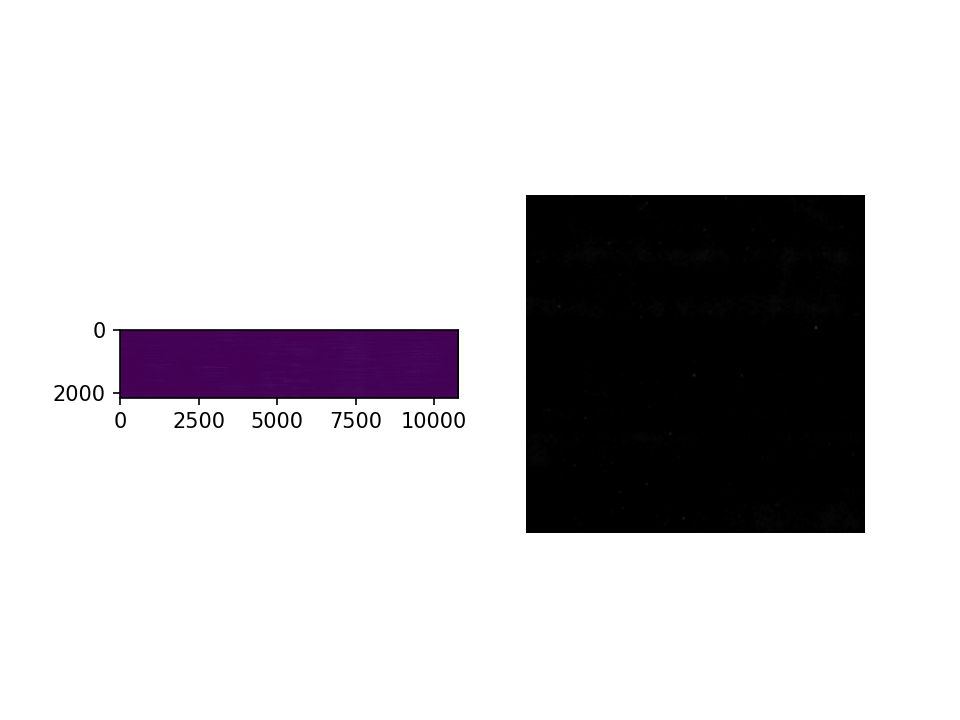

In [58]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(recon.object_recovered)
plt.clim(400, 4000)

plt.subplot(1,2,2)
beads_roi_crop_B = yp.Roi(start=(1178-32+10, 4049+10), shape=(128, 128))
plt.imshow(recon.object_recovered[beads_roi_crop_B.slice], cmap='gray')
plt.axis('off')
plt.clim(400,3000)

<IPython.core.display.Javascript object>


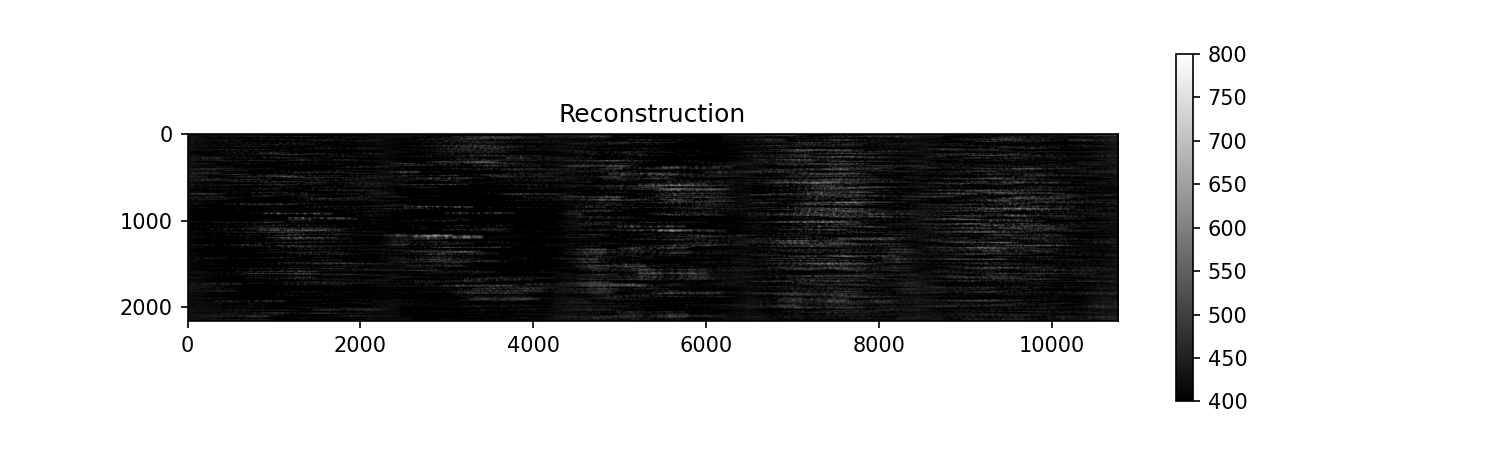

In [19]:
recon.show()
plt.clim(400,800)

In [20]:
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['npz'], save_raw=False, downsample=4)

Saved .npz file to /home/deansarah/deblurring/datasets/regularized_output/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36_no_median_regularize=[].npz


In [23]:
!ls /home/deansarah/Dropbox/res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50


background.tif
calibration.json
dark_current.tif
res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50.json
res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50.tif


In [28]:
dataset_full_path = '/home/deansarah/Dropbox/res_line_bright_coded_raster_100_motion_deblur_2019_02_05_10_52_50'
# Create dataset object (loads metadata)
dataset = MotionDeblurDataset(dataset_path=dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='')
dataset.channel_mask = [0]


Loading 1 frames...


In [29]:
force = False

# Perform registration
dataset.register(force=force)

# Perform normalization
dataset.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

Loading 3 frames...
Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    3.39e+14    |       0.00       |    0.00e+00    | 5780.2 MB /    0.0 MB  |
Met convergence requirement (delta < 1.00E-14) at iteration 3


<IPython.core.display.Javascript object>


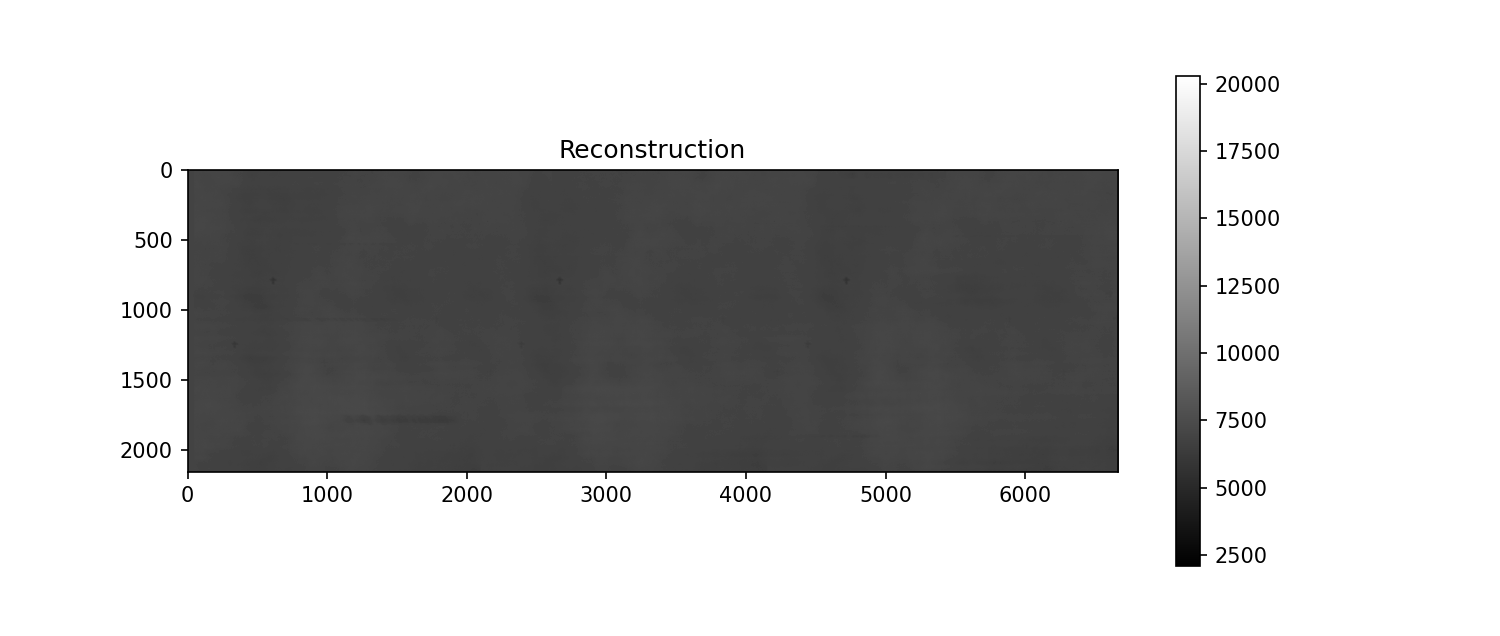

In [30]:
# dataset.motiondeblur.position_segment_indicies = [4]
dataset.frame_mask = [4,5,6]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, mode='global', reg_types={})

# Save result
# recon.save(output_path, filename=recon.dataset.metadata.file_header + '_reprocess', formats=['png', 'npz'], save_raw=True, downsample=4)
recon.show()

<IPython.core.display.Javascript object>


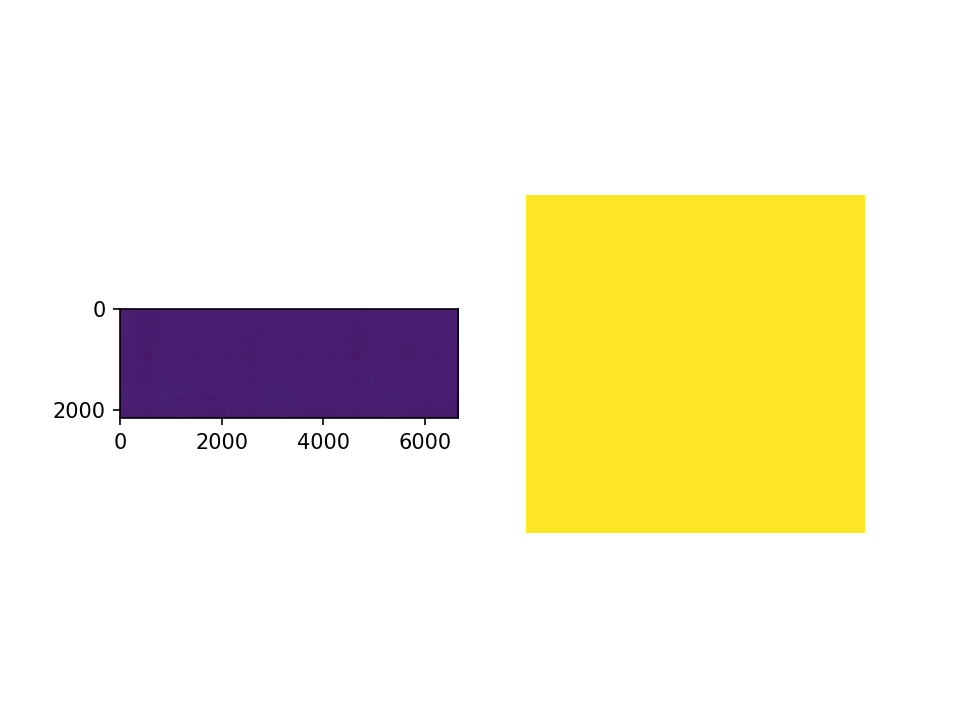

In [35]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(recon.object_recovered)
plt.clim(400, 4000)

plt.subplot(1,2,2)
res_roi_crop_B_1 = yp.Roi(start=(1000-75,4950-25), shape=(300,300))
plt.imshow(recon.object_recovered[res_roi_crop_B_1.slice])
plt.axis('off')
plt.clim(400,4000)

In [ ]:
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_reprocess', formats=['png', 'npz'], save_raw=True, downsample=4)

## Calculate DNF